In [1]:
print('mark')

mark


In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.transforms as T 
from PIL import Image
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt



/home/mark/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
data= pd.read_csv(r"/media/mark/New Volume1/ras/obejct_detection/computer_vision/data.csv")
data

,filename,width,height,class,x,y,xmax,ymax,b_width,b_height,label
0,E:/ras/Vegetation.v1i.tensorflow/train/d57f29d...,1024,321,Tree,255.00,0.00,652.00,159.00,397.0,159.0,0
1,E:/ras/Red-billed-quelea-8/select/253_png.rf.9...,640,640,quelea,183.38,354.94,239.30,436.59,55.9,81.6,1
2,E:/ras/Vegetation.v1i.tensorflow/train/c3d2b1f...,1024,683,Tree,29.00,293.00,135.00,346.00,106.0,53.0,0
3,E:/ras/Red-billed-quelea-8/select/339_jpg.rf.a...,640,640,quelea,301.56,199.08,527.05,427.27,225.5,228.2,1
4,E:/ras/Red-billed-quelea-8/select/232_jpg.rf.f...,640,640,quelea,57.77,77.71,181.48,269.21,123.7,191.5,1
...,...,...,...,...,...,...,...,...,...,...,...
3838,E:/ras/Vegetation.v1i.tensorflow/train/640ee48...,1024,768,Tree,987.00,244.00,1023.00,460.00,36.0,216.0,0
3839,E:/ras/Vegetation.v1i.tensorflow/train/5786b23...,1024,768,Tree,836.00,0.00,1023.00,765.00,187.0,765.0,0
3840,E:/ras/Vegetation.v1i.tensorflow/train/0f3c301...,1024,768,Tree,386.00,456.00,407.00,486.00,21.0,30.0,0
3841,E:/ras/Vegetation.v1i.tensorflow/train/7c2850b...,1024,681,Tree,479.00,0.00,658.00,72.00,179.0,72.0,0


In [5]:
data['filename'][1]

'E:/ras/Red-billed-quelea-8/select/253_png.rf.90e43826b3a9430e49636829b1e827a2.jpg'

In [6]:
new_root = '/media/mark/New Volume1'
data['filename'][13][2:]
change_root=[]
for i in data['filename']:
    root = new_root+ i[2:]
    change_root.append(root)

In [7]:
data['filename']= change_root

In [8]:
data.head()

,filename,width,height,class,x,y,xmax,ymax,b_width,b_height,label
0,/media/mark/New Volume1/ras/Vegetation.v1i.ten...,1024,321,Tree,255.00,0.00,652.00,159.00,397.0,159.0,0
1,/media/mark/New Volume1/ras/Red-billed-quelea-...,640,640,quelea,183.38,354.94,239.30,436.59,55.9,81.6,1
2,/media/mark/New Volume1/ras/Vegetation.v1i.ten...,1024,683,Tree,29.00,293.00,135.00,346.00,106.0,53.0,0
3,/media/mark/New Volume1/ras/Red-billed-quelea-...,640,640,quelea,301.56,199.08,527.05,427.27,225.5,228.2,1
4,/media/mark/New Volume1/ras/Red-billed-quelea-...,640,640,quelea,57.77,77.71,181.48,269.21,123.7,191.5,1


In [9]:
house=data[data['label']==2]
tree = data[data['label'] ==0]
quelea = data[data['label']==1]


In [10]:
data['label']

0       0
1       1
2       0
3       1
4       1
       ..
3838    0
3839    0
3840    0
3841    0
3842    0
Name: label, Length: 3843, dtype: int64

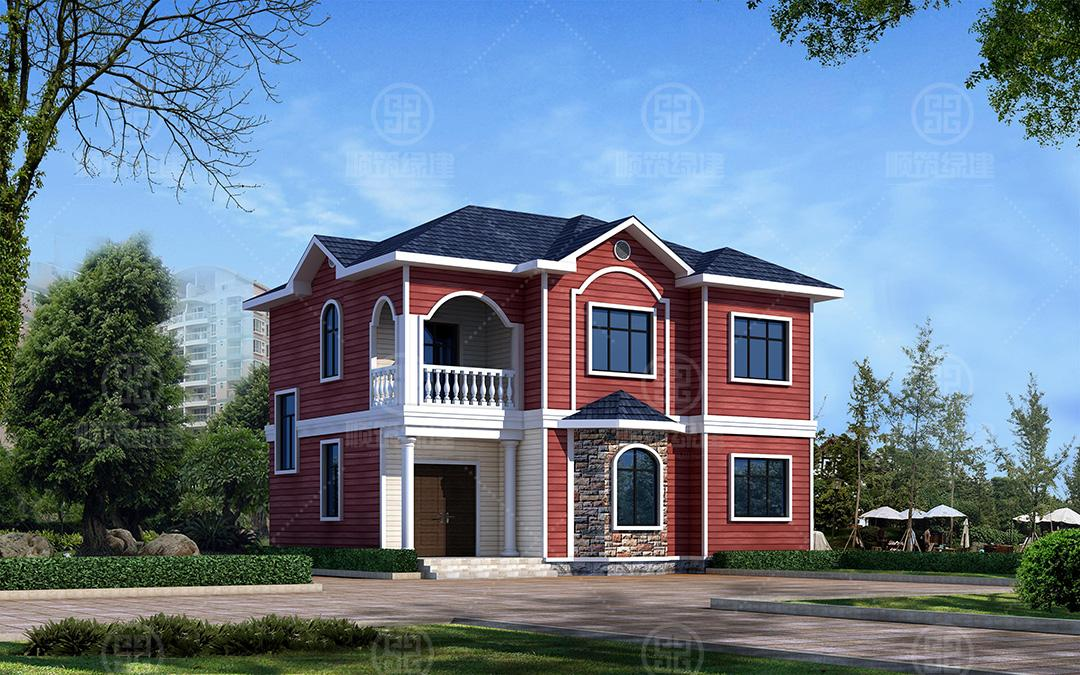

In [11]:
from IPython.display import Image
Image(data['filename'][10])

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_class = 4 #classes + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the head of the model with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

In [76]:
from PIL import Image
class CustomDataset(Dataset):
    def __init__(self,dataframe):
        self.df= dataframe
        self.transformation = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224,0.225]
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        image_path = row['filename']
        image = Image.open(image_path).convert('RGB')

        orig_w, orig_h =image.size
        # original bounding box
        x,y,w,h = row['x'], row['y'],row['b_width'], row['b_height']
        x1 ,y1,x2,y2= x,y,x+w,y+h

        image= self.transformation(image)
        scale_x = 224/orig_w
        scale_y = 224/orig_h

        x1*= scale_x
        y1*= scale_y
        x2*=scale_x
        y2*=scale_y

        boxes = torch.tensor([[x1,y1,x2,y2]], dtype=torch.float32)

        label = torch.tensor([row["label"]],dtype=torch.int32)

        target = {
            'boxes': boxes,
            'labels':label
        }

        return image ,target


In [77]:
def collate_fn(batch):
    images= [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

train_data = data.sample(frac=0.8,random_state=42).reset_index(drop=True)
val_data = data.drop(train_data.index).reset_index(drop=True)

train_dataset = CustomDataset(train_data)
val_datset = CustomDataset(val_data)

train_loader= DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_datset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [78]:
for batch in train_loader:
    img= batch[0]
    target = batch[1]
    print(img[0].shape)
    print(target[0])
    break


torch.Size([3, 224, 224])
{'boxes': tensor([[128.6250, 159.7189, 140.2188, 187.5959]]), 'labels': tensor([0], dtype=torch.int32)}


In [94]:
val_boxes =[]
val_imgs =[]
for batch in val_loader:
    images = batch[0]
    targets = batch[1]
    for t in targets:
        val_boxes.append(t['boxes'])
        val_imgs.append(images)
        


In [ ]:

all_data = []

for images, targets in val_loader:  # images: [B,C,H,W], targets: list of dicts
    # images is already a tensor of shape [batch_size, C, H, W]
    # targets is a list of dicts with keys 'boxes' and 'labels'
    
    for i in range(len(images)):
        img_tensor = images[i]  # [C,H,W]
        boxes_tensor = targets[i]['boxes']  # [num_boxes, 4]
        labels_tensor = targets[i]['labels']  # [num_boxes]
        
        all_data.append({
            "image": img_tensor,
            "boxes": boxes_tensor,
            "labels": labels_tensor
        })
    

In [109]:
see=dict(zip(val_imgs,val_boxes))
print(see)

TypeError: unhashable type: 'list'

In [80]:
# move to GPU if avaliable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
model.to(device)

# setup the optimizer
params = [p for  p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params=params, lr= 0.005)

lr_schudeler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss =0.0

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        # zero gradients
        optimizer.zero_grad()

        # forward pass
        loss_dict = model(images,targets)

        losses = sum(loss for loss in loss_dict.values())

        # backward pass
        losses.backward()
        optimizer.step()

        train_loss+=losses.item()

    lr_schudeler.step()
    print(f'Epoch:{epoch+1}, loss{train_loss/ len(train_loader)}')
print("Training complete")

# Model inference

In [ ]:
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_class = 4 #classes + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the head of the model with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)
state_dict =torch.load(r"/media/mark/New Volume1/ras/obejct_detection/Fast_rcnn_V4.pth",map_location='cpu')
model.load_state_dict(state_dict)
#model.eval()
device= torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<All keys matched successfully>

# Model evaluation

In [ ]:
# model.eval()

# with torch.no_grad():
#     for images, targets in val_loader:
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

#         predictions = model(images)
#         print(predictions[0]['boxes'])
#         print(targets[0]['labels'])

tensor([[  0.0000,   3.9682, 224.0000,  77.2816],
        [  0.0000, 145.5983, 224.0000, 218.0339],
        [ 26.4660,  33.4235, 136.1853, 219.7154],
        [  2.4144,   1.0013, 100.6917, 224.0000],
        [  0.0000,  95.4022, 141.9421, 221.7169],
        [  0.0000,  14.2067, 122.2992, 168.2794],
        [ 14.1844,   2.0940, 188.9412, 152.0171],
        [ 38.8188,  13.9360, 214.3734, 162.3841],
        [ 70.1672,  34.4448, 164.6592, 221.6743],
        [ 56.5208,  74.0296, 220.8732, 221.5340],
        [108.1217,  58.6976, 219.9923, 217.0289],
        [ 33.7442, 105.6071, 216.7998, 218.6251],
        [103.2010,  12.4709, 205.2737, 221.5273],
        [  0.0000,   3.7587, 170.1337, 113.7318]])
tensor([0], dtype=torch.int32)
tensor([[  0.0000,   0.4565, 132.9529, 131.8342],
        [ 31.6053,   2.5489, 207.5547, 119.4828],
        [ 10.7957,  21.2060, 184.6289, 172.1752],
        [  1.3309,  83.9600, 224.0000, 163.3217],
        [ 93.6014,  27.8832, 206.3728, 216.4927],
        [  1.6543,

KeyboardInterrupt: 

In [67]:
from PIL import Image
import cv2
def image_preprocessing(img):
  img = Image.open(img).convert('RGB')
  original_w, original_h = img.size
  scale_x = 224/original_w
  scale_y = 224/original_h
  
  trans = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485,0.456, 0.406],
          std=[0.229,0.224,0.225]
      )
  ])
  return trans(img)

In [17]:
house = house.reset_index(drop=True)
tree =tree.reset_index(drop=True)
quelea= quelea.reset_index(drop=True)

In [62]:
def label_map(label):
    if label ==0:
        return 'tree'
    elif label ==1:
        return 'quelea'
    elif label ==2:
        return 'house'
    else:
        return 'background'

In [68]:
plt.figure(figsize=(20,20))
def display_10_pred(img_paths:list):
    model.eval()
    boxes =[]
    labels =[]
    # run the model
    for t in img_paths:
        q = image_preprocessing(t)
        q= q.unsqueeze(0)
        with torch.no_grad():
            p = model(q)
            boxes.append(p[0]['boxes'])
            labels.append(p[0]['labels'])
    # draw the bobunding boxes
    for idx,im in enumerate(img_paths):
        plt.subplot(2,5,idx+1)
        i= cv2.imread(im)
        i= cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
        i= cv2.resize(i,(224,224))
        for b in boxes[idx][:2]:
            x1,y1,x2,y2= b
            cv2.rectangle(i, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0),2)
            cv2.putText(i, str(label_map(labels[idx][0].item())), (int(x1),int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0),2)
        plt.imshow(i)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

            

<Figure size 2000x2000 with 0 Axes>

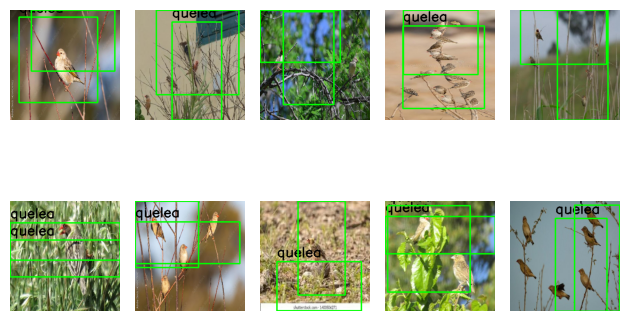

In [70]:
display_10_pred(quelea['filename'][5:15])

 - vesrion 3 has impressed

In [72]:
model.eval()
img= image_preprocessing(quelea['filename'][50])
img =img.unsqueeze(0)
with torch.no_grad():
    pred=model([img[0]])


In [74]:
pred[0]['scores'].sum()
pred[0]['labels']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2])

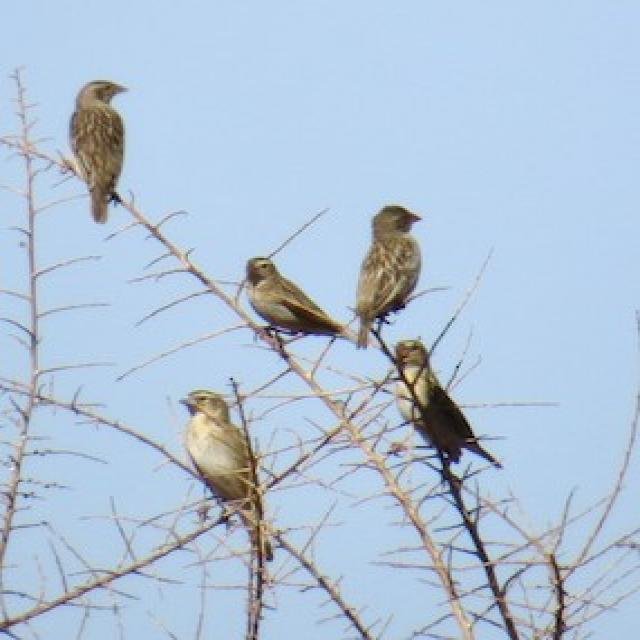

In [75]:
Image.open(quelea['filename'][50]).convert('RGB')